<a href="https://colab.research.google.com/github/amengemeda/ISproject-2/blob/main/MT5_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load libraries and data**

In [ ]:
!pip install klib sentencepiece transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 30.9 MB/s 
     |████████████████████████████████| 4.9 MB 62.9 MB/s 
     |████████████████████████████████| 133 kB 68.4 MB/s 
     |████████████████████████████████| 6.6 MB 43.5 MB/s 
     |████████████████████████████████| 120 kB 71.9 MB/s 
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import klib
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import T5Tokenizer, MT5ForConditionalGeneration
from tqdm.notebook import tqdm as tqdm_notebook_
from scipy.signal import savgol_filter
import random
import copy
import os

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
# Mounting the google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#fetch the dataset from the drive
Labels=pd.read_csv('/content/drive/MyDrive/Machine Learning/Data/Amharic-Hate-Speech-Dataset/Labels.txt',header=None)
Posts=pd.read_csv('/content/drive/MyDrive/Machine Learning/Data/Amharic-Hate-Speech-Dataset/Posts.txt',header=None)

In [ ]:
#naming the columns
Labels.columns = ["target_text"]
Posts.columns = ["input_text"]

In [ ]:
#encoding the classes into numerical data
Labels = Labels.replace(['Free', 'Free ','Hate'],['Free','Free','Hate']) 

In [ ]:
#merge the datasets
Frames = [Posts,Labels]
Merged = pd.concat(Frames, axis=1)


In [ ]:
#preview of merged data
print('Shape of the Dataframe: ', Merged.shape)
Merged.head(10)

Shape of the Dataframe:  (30000, 2)


,input_text,target_text
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,Free
1,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደ...,Free
2,የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የ...,Free
3,ከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመል...,Free
4,ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ...,Hate
5,በአማራ ህዝብ ግን ደም የገበረባትአጥንት የከሰከሰባት ሰንደቅአላማ ናትና ...,Free
6,የኢትዮጵያ ብሄራዊ ቡድን በመቀሌ እስታዲየም ሲጫወት የገቡት ደጋፊዎች በፍ...,Free
7,ዛሬም የአርሰናሉን ፔፔን የቶተንሀሙን ሰርጅ አውሪር ይዞ የገባው ኮትዲሾዋ...,Free
8,ስማ ለምን ኡነተኛ ታሪክ አታወራም ለምንስ የሰው ታሪክ ትሰርቃላቹ የኢትዮ...,Hate
9,ሀገራዊ ወግ ያለው ለሁሉ የሆነ አስገድዶ ሳይሆን በፍቅርና በልዩ ሰዋዊ አ...,Free


In [ ]:
# Upload the 'xnli15.tsv' file to the colab directory before running the cell

# df = pd.read_csv('xnli15.tsv', sep='\t')
# print('Shape of the Dataframe: ', df.shape)
# display(df.head())

In [ ]:
# Display the column headers represening each language
# print(df.columns)

In [ ]:
print(Merged.columns)

Index(['input_text', 'target_text'], dtype='object')


In [ ]:
# Modify the structure of the dataframe for the required downstream task
# data_prep = [] 
# for col in df.columns:
#   for row in df[col]:
#     data_prep.append([row, col])

# dataframe = pd.DataFrame(data_prep, columns=['input_text','target_text'])
# display(dataframe)


In [ ]:
# Data cleaning 
# dataframe=klib.data_cleaning(dataframe)
# dataframe=dataframe.drop_duplicates(subset='input_text', keep=False)


In [ ]:
# Adding prefix text to the input, which helps the model to understand the fine-tuning task objective
# dataframe['input_text'] = '<idf.lang> '+dataframe['input_text'] 
# display(dataframe)

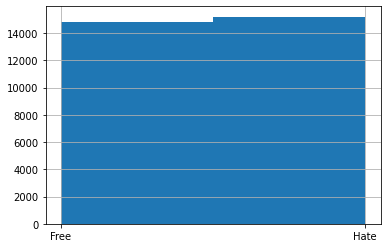

In [ ]:
Merged['target_text'].hist(bins=len(Merged.columns))

In [ ]:
# Visualizing the distribution of the examples in each language
# dataframe['target_text'].hist(bins=len(df.columns))

In [ ]:
# Splitting the dataset into train, validation, and test
train_val_df, test_df = train_test_split(Merged, test_size=0.21, random_state=42)
train_df, eval_df = train_test_split(train_val_df, test_size=0.24, random_state=42)
print('Training dataset shape: ', train_df.shape)
print('Validation dataset shape: ', eval_df.shape)
print('Testing dataset shape: ', test_df.shape)


Training dataset shape:  (18012, 2)
Validation dataset shape:  (5688, 2)
Testing dataset shape:  (6300, 2)


In [ ]:
model_repo = 'google/mt5-small'
model_path = '/content/drive/MyDrive/Machine Learning/fine-tuned_mt5/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

**Load tokenizer and model**

In [ ]:
# Loading the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = MT5ForConditionalGeneration.from_pretrained(model_repo)
model = model.cuda()

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


**Add prefixes to tokenizer**

In [ ]:
len(tokenizer.vocab)

250100

In [ ]:
print(model.config.max_length)

20


In [ ]:
# Adding the prefix <idf.lang> as a special token
# LANG_TOKEN_MAPPING = {
#     'identify language': '<idf.lang>'
# }
# special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
# special_tokens_dict

{'additional_special_tokens': ['<idf.lang>']}

In [ ]:
# Adding the special tokens to the tokenizer
# tokenizer.add_special_tokens(special_tokens_dict)

1

In [ ]:
len(tokenizer)

250100

In [ ]:
# display all special tokens
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>']

In [ ]:
model.config.vocab_size

250112

In [ ]:
# resize the input token embeddings of the model if len(tokenizer) != model.config.vocab_size
model.resize_token_embeddings(len(tokenizer))

Embedding(250100, 512)

**Encode Inputs**

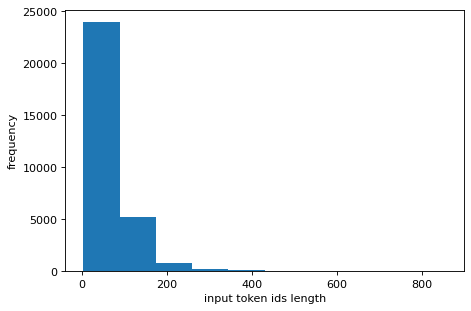

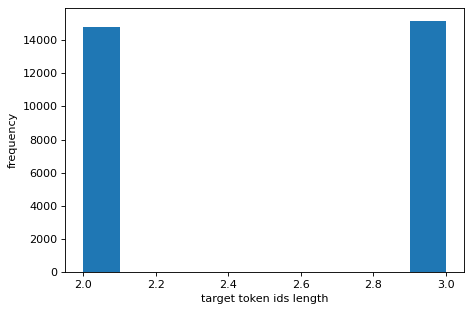

In [ ]:
# This cell encodes all the entries in the dataset to plot the token lengths histogram of 
# i/p and o/p texts, and hence execution will be little bit time consuming.

# The maximun input and output token lengths of the model are task-specific.
# Given the dataset, analyze the required token lengths for fine-tuning.

token_len = []

for row in Merged['input_text']:
  input_ids = tokenizer.encode(row, return_tensors='pt').cuda()
  token_len.append(len(input_ids[0]))

token_len.sort(reverse=True)

plt.figure(figsize=(6, 4),tight_layout=True, dpi=80)
plt.hist(token_len)
plt.xlabel('input token ids length')
plt.ylabel('frequency')
plt.savefig('/content/drive/MyDrive/Machine Learning/ip_tokens_len.jpg')


label_len = []

for row in Merged['target_text']:
  input_ids = tokenizer.encode(row, return_tensors='pt').cuda()
  label_len.append(len(input_ids[0]))
  

label_len.sort(reverse=True)

plt.figure(figsize=(6, 4),tight_layout=True, dpi=80)
plt.hist(label_len)
plt.xlabel('target token ids length')
plt.ylabel('frequency')
plt.savefig('/content/drive/MyDrive/Machine Learning/op_tokens_len.jpg')

In [ ]:
# Large input sequence length makes the training computationally very intensive
# Choose a decent value by analyzing the histogram above
max_inp_seq_len = 200
max_tar_seq_len = 3

In [ ]:
# function to encode a given string and return token ids

def encode_str(text, tokenizer, seq_len):  
  """ Tokenize, pad to max length and encode to ids 
      Returns tensor with token ids """
  input_ids = tokenizer.encode(
      text=text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

In [ ]:
# Testing the encode_str function

print(train_df['input_text'].iloc[0])
t1 = encode_str(train_df['input_text'].iloc[0],tokenizer,max_inp_seq_len)
print(t1)
tokens = tokenizer.convert_ids_to_tokens(t1)
print(tokens)

አማራ የሚለው ቃል አማረኝ ከሚለው የመጣ ነው ሁሉም ነው የሚያምራችሁ
tensor([ 1876, 48830,  4986, 10817,   259, 52466,   259, 93566,  4079, 10257,
        83498, 10817,  1237, 55029,  4476,   259,  5045,  3328,  1116,  4476,
        32241,  1116,  3035, 60103,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

In [ ]:
# Visualizing how the target texts are tokenized

uniq_lab = Merged['target_text'].unique()
for uni in uniq_lab:
  t1 = encode_str(uni,tokenizer,max_tar_seq_len)
  tokens = tokenizer.convert_ids_to_tokens(t1)
  print('Input ID: ',t1,', Tokens: ', tokens,', Decoded text: ',tokenizer.decode(t1))

Input ID:  tensor([1893,    1,    0]) , Tokens:  ['▁Free', '</s>', '<pad>'] , Decoded text:  Free</s><pad>
Input ID:  tensor([18982,   265,     1]) , Tokens:  ['▁Hat', 'e', '</s>'] , Decoded text:  Hate</s>


In [ ]:
# function to encode a given row from the dataset, containing 'input_text' and 'target_text'
# returns input and target token ids

def encode_row(row, tokenizer, seq_inp_len, seq_tar_len):
  """Encode input and tagret texts from single row"""
  """Returns input and output token ids"""
  input_text = row['input_text']
  target_text = row['target_text']

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_str(
      input_text, tokenizer, seq_inp_len)
  
  target_token_ids = encode_str(
      target_text, tokenizer, seq_tar_len)

  return input_token_ids, target_token_ids

In [ ]:
# function to encode a single batch and return input and output batch token ids

def encode_batch(batch, tokenizer):
  """Encode a single batch"""
  """Returns input and output batch token ids"""
  inputs = []
  targets = []
  for index, row in batch.iterrows():
    #gets input and output tocken ids
    formatted_data = encode_row(
        row, tokenizer, max_inp_seq_len, max_tar_seq_len)
#    print("i/o tocken ids:",formatted_data)    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    #unsqueeze(input, dim) returns a new tensor with a dimension of size one inserted at the specified position
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
#  print('squeezed tocken ids:',inputs)
  
#Concatenate the given sequence of seq tensors in the given dimension    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

In [ ]:
# function to create a generator object to generate batches of data

def data_generator(dataset, tokenizer, batch_size=32):
  """"generates batches"""
  #shuffle the data
  dataset=dataset.sample(frac=1).reset_index(drop=True)

  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield encode_batch(raw_batch, tokenizer)

In [ ]:
# Testing data generator

data_gen = data_generator(train_df, tokenizer, 8)
data_batch = next(data_gen)
#print('data_batch:',data_batch)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)


Input shape: torch.Size([8, 200])
Output shape: torch.Size([8, 3])


**Training**


In [ ]:
# defining the parameters required for fine-tuning

n_epochs = 10
train_batch_size = 10
eval_batch_size = 8
lr = 5e-4 

n_batches = int(np.ceil(len(train_df) / train_batch_size)) 
total_steps = n_epochs * n_batches 
n_warmup_steps = int(total_steps * 0.01) 

val_freq = np.ceil(10*eval_batch_size*n_batches/len(eval_df))*2
while val_freq%5 != 0:
  val_freq += 1
val_freq = round(val_freq)

print_freq = val_freq

checkpoint_freq = np.ceil(n_batches/10)
while checkpoint_freq%100 != 0:
  checkpoint_freq -= 1
checkpoint_freq = round(checkpoint_freq)


In [ ]:
print('Total Training Steps(Batches) per Epoch: '+str(n_batches))
print('Printing & Validation Frequency: '+str(val_freq))
print('Checkpoint Saving Frequency: '+str(checkpoint_freq))

Total Training Steps(Batches) per Epoch: 1802
Printing & Validation Frequency: 55
Checkpoint Saving Frequency: 100


In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
# Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, 
# after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
# Warmup is a way to reduce the primacy effect of the early training examples.
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [ ]:
# list to store the training and validation losses 

losses = []
val_losses = []

In [ ]:
# function to evaluate the model during training at a given frequency

def eval_model(model, val_generator_object, max_iters=6):
  """evaluate the model on small validation data"""
  
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(val_generator_object):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item()) 

  return np.mean(eval_losses)

In [ ]:
# fine-tuning the model and save the checkpoints

for epoch_idx in range(n_epochs):
  # generate batch data
  train_generator = data_generator(train_df, tokenizer, train_batch_size)
  val_generator = data_generator(eval_df, tokenizer, eval_batch_size)
                
  for batch_idx, (input_batch, label_batch) in tqdm_notebook_(enumerate(train_generator), total=n_batches):
    #zeroes all the gradients before the calculation
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(input_ids = input_batch, labels = label_batch)

    # Calculate loss
    loss = model_out.loss
    # loss.item() gets the scalar value held in the loss.  item() turns a Tensor into a Python number
    losses.append(loss.item())
    #backpropagation - computing the gradient of the loss function with respect to each weight
    loss.backward()
    # updating weights to minimize loss
    optimizer.step()
    #You call scheduler.step() every batch, right after optimizer.step(), to update the learning rate.
    scheduler.step()

    # Print training update info
    # At an interval of print_freq or val_freq
    if (batch_idx + 1) % print_freq == 0:
      #average loss for the last 'print_freq' batches
      avg_loss = np.mean(losses[-print_freq:])
      val_loss = eval_model(model, val_generator)
      print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, val_loss, scheduler.get_last_lr()[0]))
      val_losses.append(val_loss)
      

    # save the model for every 'checkpoint_freq' steps
    if (batch_idx + 1) % checkpoint_freq == 0:      
      torch.save(model.state_dict(), os.path.join(model_path+ 'Step-{}_checkpoint_lang_pred.pt'.format(batch_idx + 1)))

torch.save(model.state_dict(), os.path.join(model_path+ 'Step-{}_checkpoint_lang_pred.pt'.format(batch_idx + 1)))

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 1 | Step: 55 | Avg. train loss: 0.011 | Avg. val loss: 0.678 | lr: 0.0001527777777777778
Epoch: 1 | Step: 110 | Avg. train loss: 0.014 | Avg. val loss: 0.462 | lr: 0.0003055555555555556
Epoch: 1 | Step: 165 | Avg. train loss: 0.038 | Avg. val loss: 0.375 | lr: 0.0004583333333333333
Epoch: 1 | Step: 220 | Avg. train loss: 0.047 | Avg. val loss: 0.409 | lr: 0.0004988789237668162
Epoch: 1 | Step: 275 | Avg. train loss: 0.131 | Avg. val loss: 0.289 | lr: 0.0004973374439461883
Epoch: 1 | Step: 330 | Avg. train loss: 0.156 | Avg. val loss: 0.235 | lr: 0.0004957959641255606
Epoch: 1 | Step: 385 | Avg. train loss: 0.131 | Avg. val loss: 0.210 | lr: 0.0004942544843049327
Epoch: 1 | Step: 440 | Avg. train loss: 0.144 | Avg. val loss: 0.272 | lr: 0.000492713004484305
Epoch: 1 | Step: 495 | Avg. train loss: 0.162 | Avg. val loss: 0.229 | lr: 0.0004911715246636772
Epoch: 1 | Step: 550 | Avg. train loss: 0.143 | Avg. val loss: 0.264 | lr: 0.0004896300448430493
Epoch: 1 | Step: 605 | Avg. trai

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 2 | Step: 55 | Avg. train loss: 0.109 | Avg. val loss: 0.289 | lr: 0.00045299887892376686
Epoch: 2 | Step: 110 | Avg. train loss: 0.114 | Avg. val loss: 0.206 | lr: 0.00045145739910313904
Epoch: 2 | Step: 165 | Avg. train loss: 0.125 | Avg. val loss: 0.280 | lr: 0.00044991591928251123
Epoch: 2 | Step: 220 | Avg. train loss: 0.152 | Avg. val loss: 0.229 | lr: 0.00044837443946188347
Epoch: 2 | Step: 275 | Avg. train loss: 0.126 | Avg. val loss: 0.250 | lr: 0.0004468329596412556
Epoch: 2 | Step: 330 | Avg. train loss: 0.141 | Avg. val loss: 0.312 | lr: 0.0004452914798206278
Epoch: 2 | Step: 385 | Avg. train loss: 0.135 | Avg. val loss: 0.291 | lr: 0.00044374999999999997
Epoch: 2 | Step: 440 | Avg. train loss: 0.148 | Avg. val loss: 0.191 | lr: 0.0004422085201793722
Epoch: 2 | Step: 495 | Avg. train loss: 0.161 | Avg. val loss: 0.309 | lr: 0.0004406670403587444
Epoch: 2 | Step: 550 | Avg. train loss: 0.144 | Avg. val loss: 0.251 | lr: 0.0004391255605381166
Epoch: 2 | Step: 605 | Avg

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 3 | Step: 55 | Avg. train loss: 0.139 | Avg. val loss: 0.218 | lr: 0.00040249439461883407
Epoch: 3 | Step: 110 | Avg. train loss: 0.138 | Avg. val loss: 0.266 | lr: 0.00040095291479820625
Epoch: 3 | Step: 165 | Avg. train loss: 0.151 | Avg. val loss: 0.306 | lr: 0.0003994114349775785
Epoch: 3 | Step: 220 | Avg. train loss: 0.133 | Avg. val loss: 0.207 | lr: 0.0003978699551569507
Epoch: 3 | Step: 275 | Avg. train loss: 0.136 | Avg. val loss: 0.184 | lr: 0.00039632847533632286
Epoch: 3 | Step: 330 | Avg. train loss: 0.138 | Avg. val loss: 0.221 | lr: 0.0003947869955156951
Epoch: 3 | Step: 385 | Avg. train loss: 0.131 | Avg. val loss: 0.254 | lr: 0.0003932455156950673
Epoch: 3 | Step: 440 | Avg. train loss: 0.166 | Avg. val loss: 0.256 | lr: 0.0003917040358744395
Epoch: 3 | Step: 495 | Avg. train loss: 0.181 | Avg. val loss: 0.242 | lr: 0.00039016255605381166
Epoch: 3 | Step: 550 | Avg. train loss: 0.180 | Avg. val loss: 0.224 | lr: 0.0003886210762331839
Epoch: 3 | Step: 605 | Avg.

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 4 | Step: 55 | Avg. train loss: 0.102 | Avg. val loss: 0.274 | lr: 0.0003519899103139014
Epoch: 4 | Step: 110 | Avg. train loss: 0.088 | Avg. val loss: 0.290 | lr: 0.0003504484304932736
Epoch: 4 | Step: 165 | Avg. train loss: 0.080 | Avg. val loss: 0.419 | lr: 0.00034890695067264576
Epoch: 4 | Step: 220 | Avg. train loss: 0.092 | Avg. val loss: 0.309 | lr: 0.00034736547085201794
Epoch: 4 | Step: 275 | Avg. train loss: 0.094 | Avg. val loss: 0.315 | lr: 0.00034582399103139013
Epoch: 4 | Step: 330 | Avg. train loss: 0.081 | Avg. val loss: 0.329 | lr: 0.0003442825112107623
Epoch: 4 | Step: 385 | Avg. train loss: 0.085 | Avg. val loss: 0.269 | lr: 0.0003427410313901345
Epoch: 4 | Step: 440 | Avg. train loss: 0.082 | Avg. val loss: 0.336 | lr: 0.00034119955156950674
Epoch: 4 | Step: 495 | Avg. train loss: 0.097 | Avg. val loss: 0.418 | lr: 0.0003396580717488789
Epoch: 4 | Step: 550 | Avg. train loss: 0.093 | Avg. val loss: 0.315 | lr: 0.0003381165919282511
Epoch: 4 | Step: 605 | Avg.

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 5 | Step: 55 | Avg. train loss: 0.057 | Avg. val loss: 0.322 | lr: 0.0003014854260089686
Epoch: 5 | Step: 110 | Avg. train loss: 0.043 | Avg. val loss: 0.527 | lr: 0.0002999439461883408
Epoch: 5 | Step: 165 | Avg. train loss: 0.042 | Avg. val loss: 0.627 | lr: 0.000298402466367713
Epoch: 5 | Step: 220 | Avg. train loss: 0.057 | Avg. val loss: 0.191 | lr: 0.0002968609865470852
Epoch: 5 | Step: 275 | Avg. train loss: 0.050 | Avg. val loss: 0.476 | lr: 0.0002953195067264574
Epoch: 5 | Step: 330 | Avg. train loss: 0.065 | Avg. val loss: 0.397 | lr: 0.00029377802690582963
Epoch: 5 | Step: 385 | Avg. train loss: 0.052 | Avg. val loss: 0.279 | lr: 0.0002922365470852018
Epoch: 5 | Step: 440 | Avg. train loss: 0.050 | Avg. val loss: 0.278 | lr: 0.000290695067264574
Epoch: 5 | Step: 495 | Avg. train loss: 0.078 | Avg. val loss: 0.353 | lr: 0.0002891535874439462
Epoch: 5 | Step: 550 | Avg. train loss: 0.076 | Avg. val loss: 0.370 | lr: 0.00028761210762331843
Epoch: 5 | Step: 605 | Avg. tra

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 6 | Step: 55 | Avg. train loss: 0.047 | Avg. val loss: 0.480 | lr: 0.0002509809417040359
Epoch: 6 | Step: 110 | Avg. train loss: 0.036 | Avg. val loss: 0.312 | lr: 0.0002494394618834081
Epoch: 6 | Step: 165 | Avg. train loss: 0.037 | Avg. val loss: 0.578 | lr: 0.0002478979820627803
Epoch: 6 | Step: 220 | Avg. train loss: 0.057 | Avg. val loss: 0.430 | lr: 0.0002463565022421525
Epoch: 6 | Step: 275 | Avg. train loss: 0.047 | Avg. val loss: 0.499 | lr: 0.00024481502242152466
Epoch: 6 | Step: 330 | Avg. train loss: 0.044 | Avg. val loss: 0.249 | lr: 0.00024327354260089687
Epoch: 6 | Step: 385 | Avg. train loss: 0.044 | Avg. val loss: 0.385 | lr: 0.00024173206278026908
Epoch: 6 | Step: 440 | Avg. train loss: 0.070 | Avg. val loss: 0.394 | lr: 0.00024019058295964127
Epoch: 6 | Step: 495 | Avg. train loss: 0.057 | Avg. val loss: 0.228 | lr: 0.00023864910313901345
Epoch: 6 | Step: 550 | Avg. train loss: 0.051 | Avg. val loss: 0.347 | lr: 0.00023710762331838564
Epoch: 6 | Step: 605 | Av

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 7 | Step: 55 | Avg. train loss: 0.039 | Avg. val loss: 0.221 | lr: 0.00020047645739910313
Epoch: 7 | Step: 110 | Avg. train loss: 0.028 | Avg. val loss: 0.410 | lr: 0.00019893497757847534
Epoch: 7 | Step: 165 | Avg. train loss: 0.022 | Avg. val loss: 0.323 | lr: 0.00019739349775784755
Epoch: 7 | Step: 220 | Avg. train loss: 0.024 | Avg. val loss: 0.719 | lr: 0.00019585201793721974
Epoch: 7 | Step: 275 | Avg. train loss: 0.031 | Avg. val loss: 0.311 | lr: 0.00019431053811659195
Epoch: 7 | Step: 330 | Avg. train loss: 0.035 | Avg. val loss: 0.282 | lr: 0.00019276905829596414
Epoch: 7 | Step: 385 | Avg. train loss: 0.046 | Avg. val loss: 0.223 | lr: 0.00019122757847533635
Epoch: 7 | Step: 440 | Avg. train loss: 0.033 | Avg. val loss: 0.571 | lr: 0.0001896860986547085
Epoch: 7 | Step: 495 | Avg. train loss: 0.025 | Avg. val loss: 0.575 | lr: 0.00018814461883408072
Epoch: 7 | Step: 550 | Avg. train loss: 0.032 | Avg. val loss: 0.267 | lr: 0.0001866031390134529
Epoch: 7 | Step: 605 | 

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 8 | Step: 55 | Avg. train loss: 0.022 | Avg. val loss: 0.423 | lr: 0.0001499719730941704
Epoch: 8 | Step: 110 | Avg. train loss: 0.017 | Avg. val loss: 0.586 | lr: 0.0001484304932735426
Epoch: 8 | Step: 165 | Avg. train loss: 0.025 | Avg. val loss: 0.414 | lr: 0.00014688901345291482
Epoch: 8 | Step: 220 | Avg. train loss: 0.021 | Avg. val loss: 0.226 | lr: 0.000145347533632287
Epoch: 8 | Step: 275 | Avg. train loss: 0.023 | Avg. val loss: 0.429 | lr: 0.00014380605381165921
Epoch: 8 | Step: 330 | Avg. train loss: 0.021 | Avg. val loss: 0.381 | lr: 0.0001422645739910314
Epoch: 8 | Step: 385 | Avg. train loss: 0.021 | Avg. val loss: 0.246 | lr: 0.0001407230941704036
Epoch: 8 | Step: 440 | Avg. train loss: 0.022 | Avg. val loss: 0.308 | lr: 0.00013918161434977577
Epoch: 8 | Step: 495 | Avg. train loss: 0.013 | Avg. val loss: 0.456 | lr: 0.00013764013452914798
Epoch: 8 | Step: 550 | Avg. train loss: 0.028 | Avg. val loss: 0.509 | lr: 0.00013609865470852017
Epoch: 8 | Step: 605 | Avg.

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 9 | Step: 55 | Avg. train loss: 0.016 | Avg. val loss: 0.378 | lr: 9.946748878923767e-05
Epoch: 9 | Step: 110 | Avg. train loss: 0.011 | Avg. val loss: 0.464 | lr: 9.792600896860987e-05
Epoch: 9 | Step: 165 | Avg. train loss: 0.015 | Avg. val loss: 0.429 | lr: 9.638452914798207e-05
Epoch: 9 | Step: 220 | Avg. train loss: 0.015 | Avg. val loss: 0.234 | lr: 9.484304932735425e-05
Epoch: 9 | Step: 275 | Avg. train loss: 0.012 | Avg. val loss: 0.520 | lr: 9.330156950672645e-05
Epoch: 9 | Step: 330 | Avg. train loss: 0.015 | Avg. val loss: 0.382 | lr: 9.176008968609865e-05
Epoch: 9 | Step: 385 | Avg. train loss: 0.021 | Avg. val loss: 0.505 | lr: 9.021860986547085e-05
Epoch: 9 | Step: 440 | Avg. train loss: 0.016 | Avg. val loss: 0.352 | lr: 8.867713004484305e-05
Epoch: 9 | Step: 495 | Avg. train loss: 0.013 | Avg. val loss: 0.421 | lr: 8.713565022421525e-05
Epoch: 9 | Step: 550 | Avg. train loss: 0.018 | Avg. val loss: 0.522 | lr: 8.559417040358743e-05
Epoch: 9 | Step: 605 | Avg. tra

  0%|          | 0/1802 [00:00<?, ?it/s]

Epoch: 10 | Step: 55 | Avg. train loss: 0.015 | Avg. val loss: 0.622 | lr: 4.8963004484304934e-05
Epoch: 10 | Step: 110 | Avg. train loss: 0.009 | Avg. val loss: 0.584 | lr: 4.742152466367713e-05
Epoch: 10 | Step: 165 | Avg. train loss: 0.009 | Avg. val loss: 0.745 | lr: 4.5880044843049326e-05
Epoch: 10 | Step: 220 | Avg. train loss: 0.011 | Avg. val loss: 0.752 | lr: 4.4338565022421525e-05
Epoch: 10 | Step: 275 | Avg. train loss: 0.009 | Avg. val loss: 0.486 | lr: 4.279708520179372e-05
Epoch: 10 | Step: 330 | Avg. train loss: 0.009 | Avg. val loss: 0.771 | lr: 4.125560538116592e-05
Epoch: 10 | Step: 385 | Avg. train loss: 0.012 | Avg. val loss: 0.481 | lr: 3.971412556053812e-05
Epoch: 10 | Step: 440 | Avg. train loss: 0.010 | Avg. val loss: 0.287 | lr: 3.8172645739910314e-05
Epoch: 10 | Step: 495 | Avg. train loss: 0.013 | Avg. val loss: 0.751 | lr: 3.663116591928251e-05
Epoch: 10 | Step: 550 | Avg. train loss: 0.012 | Avg. val loss: 0.515 | lr: 3.508968609865471e-05
Epoch: 10 | Step:

In [ ]:
# save the training and validation loss values

if not os.path.exists('/content/drive/MyDrive/Machine Learning/Loss'):
  os.mkdir('/content/drive/MyDrive/Machine Learning/Loss')

pd.DataFrame(losses).to_csv("/content/drive/MyDrive/Machine Learning/Loss/train_loss.csv")
pd.DataFrame(val_losses).to_csv("/content/drive/MyDrive/Machine Learning/Loss/val_loss.csv")

In [ ]:
# Load the loss values

train_loss_= pd.read_csv('/content/drive/MyDrive/Machine Learning/Loss/train_loss.csv', index_col=0)
val_loss_= pd.read_csv('/content/drive/MyDrive/Machine Learning/Loss/val_loss.csv', index_col=0)


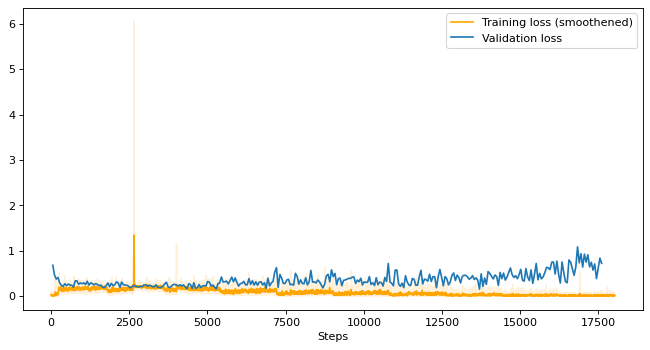

In [ ]:
# visualizing the training and validation losses

# Actual training loss with low opacity
fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(train_loss_, alpha=0.15, color='orange')

# smoothening the training loss
# window size is chosen depending upon the amount of smoothening required
window = 11
order = 1
y_ = savgol_filter(train_loss_['0'], window, order)
plt.plot(y_, color='orange', label='Training loss (smoothened)')

# Validation loss
val_loss_df = copy.deepcopy(val_loss_) 
val_loss_df.index = (val_loss_.index+1)*val_freq
plt.plot(val_loss_df, label='Validation loss')

plt.legend(loc="upper right")
plt.xlabel('Steps')

# save the plot if needed
fig.savefig('/content/drive/MyDrive/Machine Learning/Loss/Loss_Plot.png', dpi=fig.dpi)

**Model Testing**

In [ ]:
# function to test the model on 'max_iter' examples 

def test_model(test_df, tokenizer, wrong_prediction, max_iter):

  max_test_iters = max_iter
  correct_predictions = 0

  for _ in range(max_test_iters):
    num = random.randint(0,len(test_df['input_text'])-1)
    test = test_df.iloc[num]

    input_ids = encode_str(text = test['input_text'], tokenizer = tokenizer, seq_len = 40)
    input_ids = input_ids.unsqueeze(0).cuda()

    #print('Truncated input text:', tokenizer.convert_tokens_to_string(
    #  tokenizer.convert_ids_to_tokens(input_ids[0])))

    output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
    # print(output_tokens)
    for token_set in output_tokens:
      prediction = tokenizer.decode(token_set,skip_special_tokens=True)
      if prediction == test['target_text']:
        correct_predictions += 1
      else:
        wrong_prediction.append([test['input_text'], test['target_text'], prediction])

  return correct_predictions/max_test_iters, wrong_prediction

In [ ]:
# test the model on multiple batches to find average test accuracy.
# wrong predictions are saved to 'wrong_predictions.csv' file for further analysis.

Test_acc_values = []
wrong_pred = []
test_n_batches = 200
print('Model testing on test dataset: \n')
for _ in tqdm_notebook_(range(test_n_batches)):
  acc, wrong_pred = test_model(test_df, tokenizer, wrong_pred, max_iter=50)
  Test_acc_values.append(acc)


print('Avg. Test Accuracy: {:.4f}'.format(np.mean(Test_acc_values))) 
wrong_pred_df = pd.DataFrame (wrong_pred, columns = ['Input_text', 'True_target', 'Predicted'])
# wrong_pred_df.to_csv("/content/drive/MyDrive/Machine Learning/wrong_predictions.csv")


Model testing on test dataset: 



  0%|          | 0/200 [00:00<?, ?it/s]

Avg. Test Accuracy: 0.6337


**Load the weights (post-training part)**

In [ ]:
# After fine-tuning, if we need to load the saved model checkpoint.
# If using different checkpoint saving frequency during training, then make sure to change the corresponding filename.

# model_name=model_path+'Step-5623_checkpoint_lang_pred.pt'
# model.load_state_dict(torch.load(model_name))

<All keys matched successfully>